# Demonstration: using demosaicing for forgery detection

This notebook aims at providing example on how to use demosaicing for forgery detection. The principle of the method is explained proposed by Quentin Bammey, Rafael Grompone von Gioi and Jean-Michel Morel in the article "Demosaicing to Detect Demosaicing and Image Forgeries".

The idea is to detect if two different demosaicing algorithms are present in a image, which is a proof that is was forged. Let's illustrate this.

**Few implementation details:**
* The three demosaicing we tested here are the one implemented in the Python Library `colour-demosaicing`: `bilinear` (simple bilinear interpolation of the colours), `malvar` (paper "High-quality linear interpolation for demosaicing of bayer-patterned colour images", Malvar et al, 2004), and `menon` (paper "Demosaicing with directional filtering and a posteriori decision", Menon et al, 2007). Admittedly, those are ancient, old demosaicing algorithms. However, if we can observe those limitations with those simple algorithms, there is no reason why they would bo fully absent with in a collection of more recent algorithms.
* The four patters we test are all Bayer CFA patterns: `RGGB`, `BGGR`, `GRBG`, `GBRG`
* When there is a tie for the approximation of a 2x2 block, the tie is breaken using a random choice among all configurations that minimize the mean of the absolute L1 reconstruction error.

## Set up

You should run this notebook with `Python 3.11`, having installed the dependencies in `requirements.txt` and with your PYTHONPATH set to the root of the repository.

The following lines should do this for you. The first outputed line should be a path to the root of the repository.

In [1]:
from pathlib import Path
import os
while not (Path('requirements.txt')).exists():
    os.chdir('..')
    
!pwd
%pip install -r requirements.txt
!export PYTHONPATH=$(pwd)

/Users/jeremie/Documents/02-Scolarité/01-MVA/03-Cours_S2/03-DetectionTheory/demosaicing-detection
Note: you may need to restart the kernel to use updated packages.


In [2]:
from src.experiments.evaluate_forgery_detection import generate_forged_image
from src.forgery_tools.detect import *

from matplotlib import pyplot as plt
import numpy as np

from src.forgery_tools.forge import generate_forged_image, generate_unforged_image
from src.forgery_tools.vote import get_block_votes
from src.forgery_tools.detect import detect_config

%matplotlib inline
np.random.seed(4)

        9528ms INFO  [datasets.py] Initiating a dataset over the no_noise_images dataset
        9529ms INFO  [datasets.py] More info at http://mcolom.info/pages/no_noise_images/
        9531ms INFO  [datasets.py] no_noise_images found at /data/no_noise_images


## Generating a forged image

The following line will generate an forged image. More precisely, two things are done in this example:
* The full image goes under a first mosaicing-demosaicing step with `bilinear` algorithm and pattern `GBRG` (those are sampled randomly)
* Then, the rectangle between position (109, 94) and (309, 294) goes again under a mosaicing-demosaicing step with algorithm `malvar` and pattern `RGGB`.
* Both the positions of the rectangle and the new configuration (algo, pattern) are sampled randomly.

In [3]:
forged_image = generate_forged_image(verbose = True)

        9971ms INFO  [forge.py] Creating a demosaicing forgery ('bilinear', 'GBRG') -> ('malvar', 'RGGB')
        9972ms INFO  [forge.py] Forgery start and stop: (109, 94) ->  (309, 294)


Now, let's check the image. As for every demosaicing-based forgery, we can't see that the image is forged with our naked eyes.

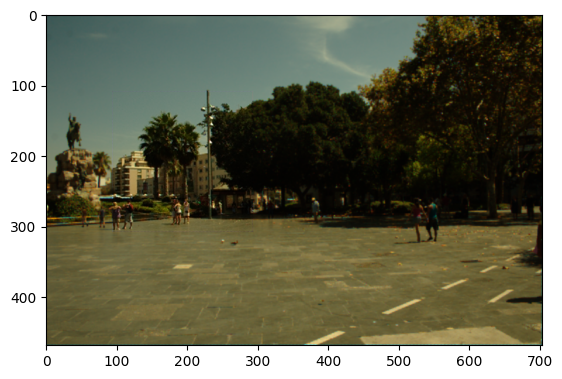

In [4]:
plt.imshow(forged_image)
plt.show()
plt.close()

However, if we use the method proposed in the paper, the forgery becomes clearly visible. In the following cells, we see that the votes are different in the forged and unforged area of the image, which lead to the detection of the forgery with very high log-NFA.

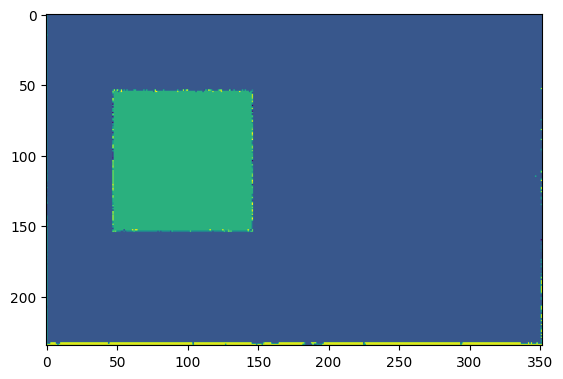

Votes for each of the 12 configurations (algo, pattern):
0:9
1:6
2:15
3:71484
4:41
5:93
6:463
7:9731
8:102
9:48
10:395
11:333
Num votes = 82720
Detection: 3 with -log(NFA)=inf


In [5]:
votes = get_block_votes(forged_image) # The votes for the configuration (algo, pattern) as int between 0 and 11
plt.imshow(votes)
plt.show()
plt.close()
print('Votes for each of the 12 configurations (algo, pattern):')
votes_count = 0
for value, count in zip(*np.unique(votes, return_counts=True)):
    print(f'{value}:{count}')
    votes_count += count
print(f'Num votes = {votes_count}')
config, nfa = detect_config(votes, len(ALGO_PATTERN_CONFIG)) # Detection of the algorithm: -1 for no detection
print(f'Detection: {config} with -log(NFA)={nfa}')

In [6]:
detect_forgery(
    votes,
    num_configs=12,
    windows_size=100,
    nfa_threshold=None,
)

(True, inf)

### Another example with compression

Now, let's do this again with a JPEG90 compression after the generation of the image. We'll see that the forgery remains detectable!

       11691ms INFO  [forge.py] Creating a demosaicing forgery ('bilinear', 'RGGB') -> ('menon', 'BGGR')
       11692ms INFO  [forge.py] Forgery start and stop: (115, 226) ->  (315, 426)


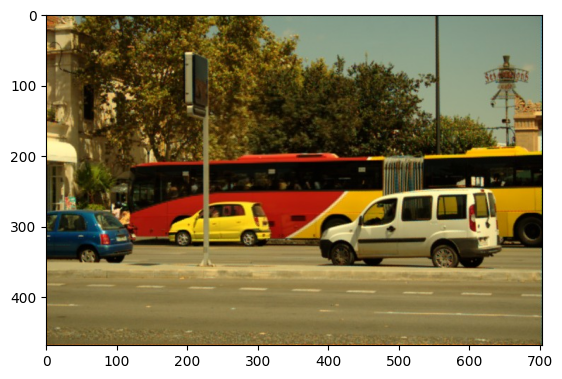

In [7]:
forged_image = generate_forged_image(verbose = True, jpeg_compression=90)
plt.imshow(forged_image)
plt.show()
plt.close()

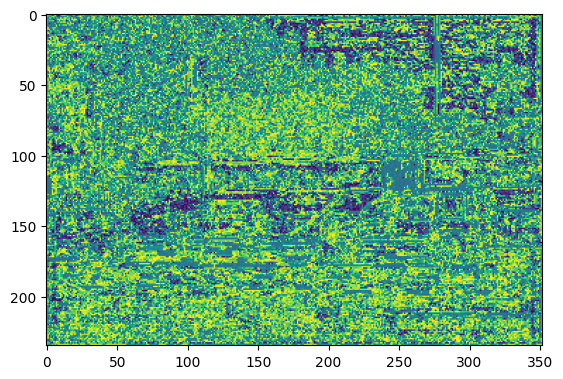

Votes for each of the 12 configurations (algo, pattern):
0:3644
1:3111
2:3227
3:3151
4:13578
5:9791
6:5557
7:5058
8:8983
9:8112
10:9676
11:8832
Num votes = 82720
Detection: 4 with -log(NFA)=inf


In [8]:
votes = get_block_votes(forged_image) # The votes for the configuration (algo, pattern) as int between 0 and 11
plt.imshow(votes)
plt.show()
plt.close()
print('Votes for each of the 12 configurations (algo, pattern):')
votes_count = 0
for value, count in zip(*np.unique(votes, return_counts=True)):
    print(f'{value}:{count}')
    votes_count += count
print(f'Num votes = {votes_count}')
config, nfa = detect_config(votes, len(ALGO_PATTERN_CONFIG)) # Detection of the algorithm: -1 for no detection
print(f'Detection: {config} with -log(NFA)={nfa}')

Here, the forgery is really difficult to detect, even on the vote map, using our naked eyes. However, the a-contrario setting enables us to detect the forgery with a very high confidence: here, the NFA is 54.77, which means one false alarm every 10^54.77 times! 

By the way, if we pay attention to the middle of the voting map, we see that there is an exess of yellow dots in a square, and this is what is detected by the a-contrario algorithm.

In [9]:
detect_forgery(
    votes,
    num_configs=12,
    windows_size=100,
    nfa_threshold=None,
)

(True, 140.53433816250055)

### An example of non-detection 

Now, let's see an example where the forgery is not detected. To do so, we'll use a JPEG80 compression, which makes the demosaicing forgeries very hard to detect.

In this example, with a NFA threshold set at $10^{-3}$, the forgery is not detected by our algorithm.

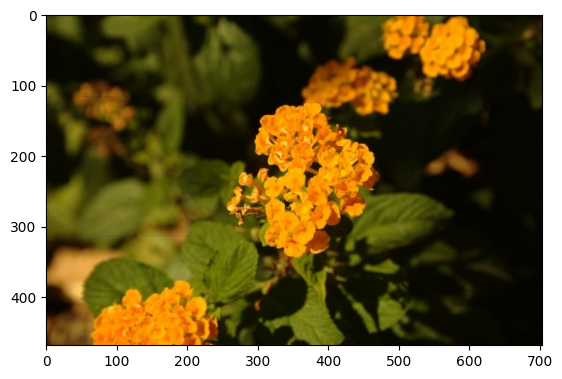

Found a no-detection after 5 JPEG90 tries, log-NFA of the no-detection = 1.2739991265310682


In [10]:
np.random.seed(0)
detected = True
count = 0
nfa_threshold = 1e-3

while detected and count < 30:
    forged_image = generate_forged_image(verbose = False, jpeg_compression=90)

    # Detection with NFA threshold 10^-
    votes = get_block_votes(forged_image)
    detected, log_nfa = detect_forgery(
        votes,
        num_configs=12,
        windows_size=100,
        nfa_threshold=nfa_threshold,
    )

    if detected:
        count += 1

if not detected:
    plt.imshow(forged_image)
    plt.show()
    plt.close()
    print(f'Found a no-detection after {count} JPEG90 tries, log-NFA of the no-detection = {log_nfa}')
else:
    print(f'Not able to found no-detection after {count} tries.')

### An example of false detection

Here is an example of false detection. To get one, we need to perform a JPEG compression, since we were not able to observe any false detection without compression.

However, we see here that we detect false detection with high log-NFA (here, about 21). This is unexpected and shows that the a-contrario hypothesis are not correctly validated here. Cf our report for a more detailed discussion on this.

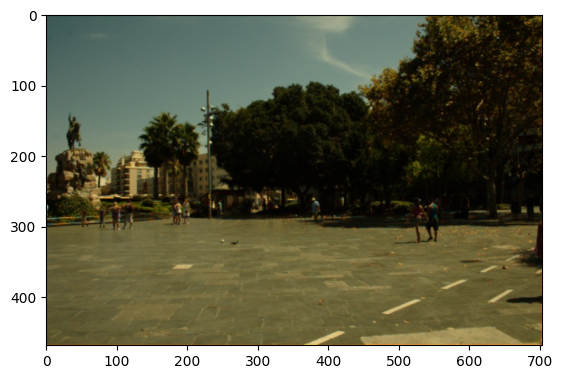

Found a false detection after 0 JPEG95 tries, log-NFA of the false detection = 21.196340742025452


In [11]:
np.random.seed(6)
detected = False
count = 0
nfa_threshold = 1e-0

while not detected and count < 30:
    forged_image = generate_unforged_image(verbose = False, jpeg_compression=95)

    # Detection with NFA threshold 10^-3
    votes = get_block_votes(forged_image)
    detected, log_nfa = detect_forgery(
        votes,
        num_configs=12,
        windows_size=100,
        nfa_threshold=nfa_threshold,
    )

    if not detected:
        count += 1

if detected:
    plt.imshow(forged_image)
    plt.show()
    plt.close()
    print(f'Found a false detection after {count} JPEG95 tries, log-NFA of the false detection = {log_nfa}')
else:
    print(f'Not able to found no-detection after {count} tries.')

In [12]:
detect_forgery(
    votes,
    windows_size=100,
    num_configs=12,
    nfa_threshold=None,
)

(True, 21.196340742025452)